In [ ]:
! pip install kaggle

In [ ]:
!kaggle datasets download -d vetion/vege-quality

Dataset URL: https://www.kaggle.com/datasets/vetion/vege-quality
License(s): DbCL-1.0
 99% 32.0M/32.4M [00:02<00:00, 21.8MB/s]
100% 32.4M/32.4M [00:02<00:00, 13.0MB/s]


In [ ]:
! unzip vege-quality

Archive:  vege-quality.zip
  inflating: Vegetables/test/Brokoli Hijau Bagus/005.jpg  
  inflating: Vegetables/test/Brokoli Hijau Bagus/006.jpg  
  inflating: Vegetables/test/Brokoli Hijau Bagus/008.jpg  
  inflating: Vegetables/test/Brokoli Hijau Bagus/0121.jpg  
  inflating: Vegetables/test/Brokoli Hijau Bagus/0127.jpg  
  inflating: Vegetables/test/Brokoli Hijau Bagus/0129.jpg  
  inflating: Vegetables/test/Brokoli Hijau Bagus/014.jpg  
  inflating: Vegetables/test/Brokoli Hijau Bagus/018.jpg  
  inflating: Vegetables/test/Brokoli Hijau Bagus/034.jpg  
  inflating: Vegetables/test/Brokoli Hijau Bagus/037.jpg  
  inflating: Vegetables/test/Brokoli Hijau Bagus/040.jpg  
  inflating: Vegetables/test/Brokoli Hijau Bagus/042.jpeg  
  inflating: Vegetables/test/Brokoli Hijau Bagus/047.jpg  
  inflating: Vegetables/test/Brokoli Hijau Bagus/0993.jpg  
  inflating: Vegetables/test/Brokoli Hijau Bagus/0994.jpg  
  inflating: Vegetables/test/Brokoli Hijau Bagus/1002.jpg  
  inflating: Vegetable

In [ ]:
!pip install silence_tensorflow

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for silence_tensorflow: filename=silence_tensorflow-1.2.1-py3-none-any.whl size=4465 sha256=4ced75bc94d36721e59623d0095a1f6f79f43eadbdfc44eb24c28325785559f2
  Stored in directory: /root/.cache/pip/wheels/7d/2c/24/e130d6102c0df56631b9db7479d9a6a53c5d97fb06b5f61b98
  Created wheel for support_developer: filename=support_developer-1.0.5-py3-none-any.whl size=5630 sha256=875995465c12bc6738f70173eeba4ebf9aa1b85b66fc3cdcbf96b2f89e349ed4
  Stored in directory: /root/.cache/pip/wheels/b6/72/c8/3054a5897ba0713dfa7a941364d68cbd42b0755c8e2ec1c18c
Successfully built silence_tensorflow support_developer


In [ ]:
# A function to avoid tensorflow warnings
from silence_tensorflow import silence_tensorflow
silence_tensorflow()

# **IMPORT LIBRARY**

In [ ]:
import os
import cv2
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from termcolor import colored
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.utils import plot_model
from tensorflow.keras import optimizers
from tensorflow.keras import models, layers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
print(tf.__version__)

2.15.0


In [ ]:
sns.set_style('darkgrid')
warnings.filterwarnings('ignore')

# **IMPORT DATA**

In [ ]:
base_dir = '/content/Vegetables'

In [ ]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# **Count data and classes**

In [ ]:
def num_of_classes(folder_dir, folder_name) :
    classes = [class_name for class_name in os.listdir(train_dir)]
    print(colored(f'number of classes in {folder_name} folder : {len(classes)}', 'blue', attrs=['bold']))

In [ ]:
num_of_classes(train_dir, 'train')
num_of_classes(validation_dir, 'validation')
num_of_classes(test_dir, 'test')

number of classes in train folder : 20
number of classes in validation folder : 20
number of classes in test folder : 20


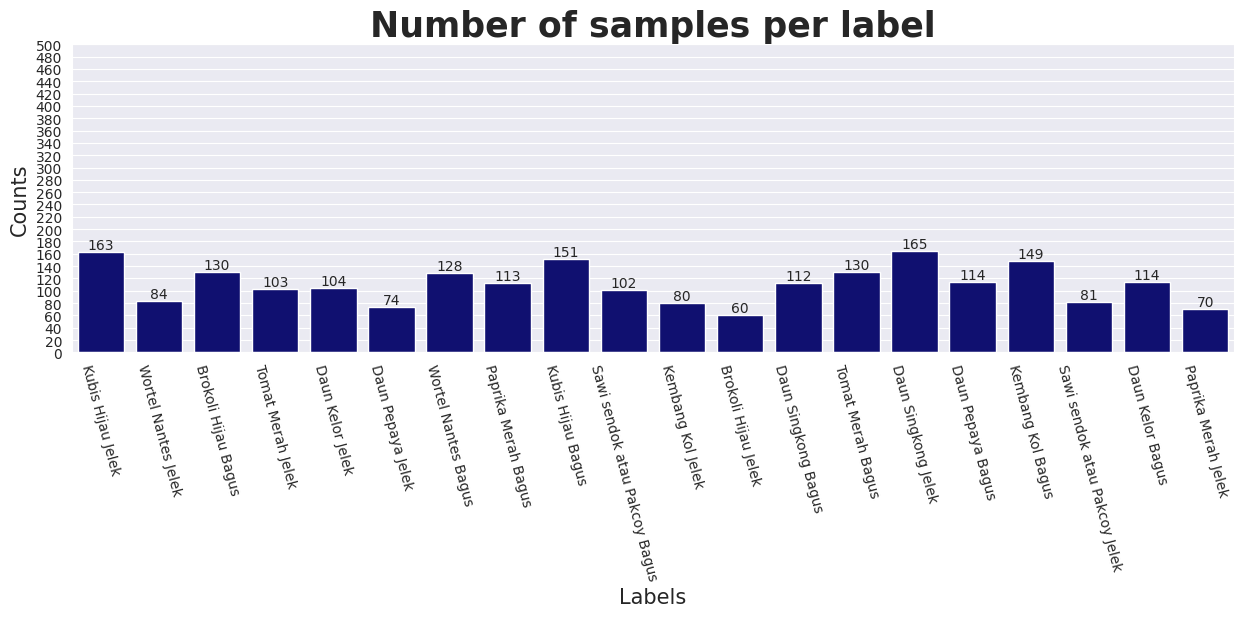

In [ ]:
classes = [class_name for class_name in os.listdir(train_dir)]
count = []
for class_name in classes :
    count.append(len(os.listdir(os.path.join(train_dir, class_name))))

plt.figure(figsize=(15, 4))
ax = sns.barplot(x=classes, y=count, color='navy')
plt.xticks(rotation=285)
for i in ax.containers:
    ax.bar_label(i,)
plt.title('Number of samples per label', fontsize=25, fontweight='bold')
plt.xlabel('Labels', fontsize=15)
plt.ylabel('Counts', fontsize=15)
plt.yticks(np.arange(0, 505, 20))
plt.show()

# **Convert data to a DataFrame**

In [ ]:
# A function to return DataFrame

def create_df(folder_path) :
    all_images = []
    for class_name in classes :
        class_path = os.path.join(folder_path, class_name)
        all_images.extend([(os.path.join(class_path, file_name), class_name) for file_name in os.listdir(class_path)])
    df = pd.DataFrame(all_images, columns=['file_path', 'label'])
    return df

In [ ]:
train_df = create_df(train_dir)
validation_df = create_df(validation_dir)
test_df = create_df(test_dir)

In [ ]:
print(colored(f'Number of samples in train : {len(train_df)}', 'blue', attrs=['bold']))
print(colored(f'Number of samples in validation : {len(validation_df)}', 'blue', attrs=['bold']))
print(colored(f'Number of samples test : {len(test_df)}', 'blue', attrs=['bold']))

Number of samples in train : 2227
Number of samples in validation : 471
Number of samples test : 497


# **visualisasi image**

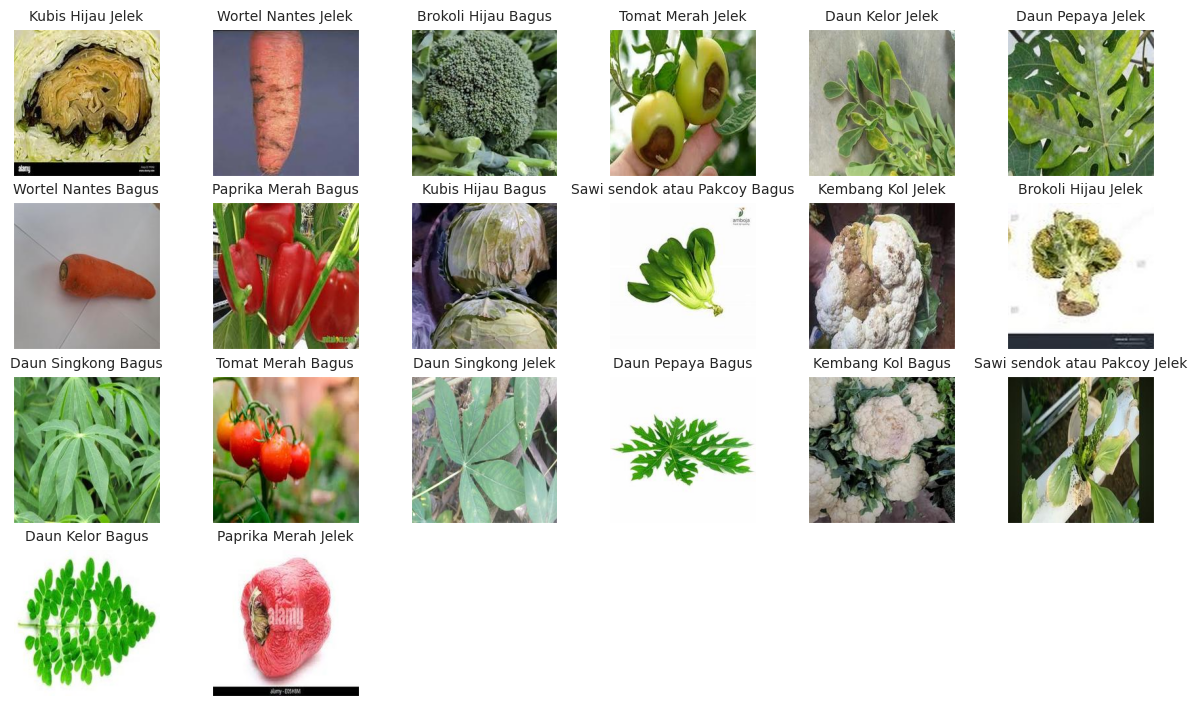

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming train_df is already defined
df_unique = train_df.copy().drop_duplicates(subset=["label"]).reset_index()

# Number of unique labels
num_unique_labels = df_unique.shape[0]

# Calculate the number of rows and columns needed for subplots
nrows = (num_unique_labels // 6) + 1
ncols = min(num_unique_labels, 6)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 7),
                         subplot_kw={'xticks': [], 'yticks': []})

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i, ax in enumerate(axes[:num_unique_labels]):
    ax.imshow(plt.imread(df_unique.file_path[i]))
    ax.set_title(df_unique.label[i], fontsize=10)

# Hide any remaining subplots if there are any
for ax in axes[num_unique_labels:]:
    ax.axis('off')

plt.tight_layout(pad=0.5)
plt.show()


# **Data generators**

In [ ]:
# Train generator

train_datagen = ImageDataGenerator(
    rescale=1./255,                 # Scaled images in range 0 to 1
    rotation_range=20,              # Rorate images by factor 20 degree
    width_shift_range=0.2,          # Shift images horizontally by up to 20% of their width
    height_shift_range=0.2,         # Shift images vertically by up to 20% of their width
    zoom_range=0.1,                 # Zoom in and out images by 10%
    horizontal_flip=True,           # Allow horizontal flipping
    shear_range=0.1,                # shear images by 10% their size
    fill_mode='nearest',            # fill unlocated pixels by nearest pixel
    )

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,             # Target data
    x_col='file_path',              # X column
    y_col='label',                  # y column
    target_size=(224, 224),         # Resize images  to
    color_mode='rgb',               # Color mode
    class_mode='categorical',       # type of model
    batch_size=32,
    shuffle=True,
    seed=42,

)

Found 2227 validated image filenames belonging to 20 classes.


In [ ]:
validation_datagen = ImageDataGenerator(rescale=1./255,)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=validation_df,
    x_col='file_path',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    seed=42,
    shuffle=False
)

Found 471 validated image filenames belonging to 20 classes.


In [ ]:
# Test generator

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='file_path',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    seed=42,
    shuffle=False
)

Found 497 validated image filenames belonging to 20 classes.


# **Build MobileNetV2 model**

In [ ]:
pre_trained_model = MobileNetV2(
    input_shape=(224, 224, 3),            # Input image size
    include_top=False,                    # model not include top layer
    weights='imagenet',                   # weights type
    classifier_activation='softmax',      # activation function
    pooling='avg'                         # type of pooling layer
)

9406464/9406464 [==============================] - 2s 0us/step


# **Freeze MobileNetV2 layers**

In [ ]:
# Name of layers in MobileNetV2
for layer in pre_trained_model.layers :
    print(layer.name)


input_1
Conv1
bn_Conv1
Conv1_relu
expanded_conv_depthwise
expanded_conv_depthwise_BN
expanded_conv_depthwise_relu
expanded_conv_project
expanded_conv_project_BN
block_1_expand
block_1_expand_BN
block_1_expand_relu
block_1_pad
block_1_depthwise
block_1_depthwise_BN
block_1_depthwise_relu
block_1_project
block_1_project_BN
block_2_expand
block_2_expand_BN
block_2_expand_relu
block_2_depthwise
block_2_depthwise_BN
block_2_depthwise_relu
block_2_project
block_2_project_BN
block_2_add
block_3_expand
block_3_expand_BN
block_3_expand_relu
block_3_pad
block_3_depthwise
block_3_depthwise_BN
block_3_depthwise_relu
block_3_project
block_3_project_BN
block_4_expand
block_4_expand_BN
block_4_expand_relu
block_4_depthwise
block_4_depthwise_BN
block_4_depthwise_relu
block_4_project
block_4_project_BN
block_4_add
block_5_expand
block_5_expand_BN
block_5_expand_relu
block_5_depthwise
block_5_depthwise_BN
block_5_depthwise_relu
block_5_project
block_5_project_BN
block_5_add
block_6_expand
block_6_expand

In [ ]:
# Freeze all layers, except last layer
# The goal is to train just last layer of pre trained model

pre_trained_model.trainable = True
set_trainable = False

for layer in pre_trained_model.layers :
    if layer.name == 'block_16_expand' :
        set_trainable = True
    if set_trainable :
        layer.trainable = True
    else :
        layer.trainable = False

# **Mendefinisikan model**

In [ ]:
# Add custom layers on top of the base model
model = models.Sequential()
model.add(pre_trained_model)

model.add(layers.Flatten())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(20, activation='softmax'))


In [ ]:
plot_model(model, show_shapes=True, show_layer_names=False, dpi=200)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dense_1 (Dense)             (None, 20)                5140      
                                                                 
Total params: 2591060 (9.88 MB)
Trainable params: 1219156 (4.65 MB)
Non-trainable params: 1371904 (5.23 MB)
______________

# **Compile Model**

In [ ]:
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [ ]:
# Model CheckPoint
checkpoint_cb = ModelCheckpoint('my_model.keras', save_best_only=True)

# Early Stoping
earlystop_cb = EarlyStopping(patience=10, restore_best_weights=True)

# ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)

# **Train Model**

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=100,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[checkpoint_cb, earlystop_cb, reduce_lr]
)

Epoch 1/100
70/70 [==============================] - 50s 438ms/step - loss: 1.7916 - accuracy: 0.5101 - val_loss: 0.9737 - val_accuracy: 0.6582 - lr: 1.0000e-04
Epoch 2/100
70/70 [==============================] - 29s 420ms/step - loss: 0.7036 - accuracy: 0.7916 - val_loss: 0.8372 - val_accuracy: 0.6985 - lr: 1.0000e-04
Epoch 3/100
70/70 [==============================] - 29s 414ms/step - loss: 0.4622 - accuracy: 0.8590 - val_loss: 0.7551 - val_accuracy: 0.7537 - lr: 1.0000e-04
Epoch 4/100
70/70 [==============================] - 29s 416ms/step - loss: 0.3658 - accuracy: 0.8904 - val_loss: 0.6672 - val_accuracy: 0.7877 - lr: 1.0000e-04
Epoch 5/100
70/70 [==============================] - 30s 423ms/step - loss: 0.2869 - accuracy: 0.9106 - val_loss: 0.6333 - val_accuracy: 0.8068 - lr: 1.0000e-04
Epoch 6/100
70/70 [==============================] - 29s 409ms/step - loss: 0.2601 - accuracy: 0.9151 - val_loss: 0.5320 - val_accuracy: 0.8514 - lr: 1.0000e-04
Epoch 7/100
70/70 [===============

# **Plot the result of training**

In [ ]:
# Convert resutl of training to a DataFrame
result_df = pd.DataFrame(history.history)
result_df.tail()

loss  accuracy  val_loss  val_accuracy        lr
51  0.033197  0.994163  0.314057      0.923567  0.000003
52  0.034810  0.989672  0.313757      0.923567  0.000003
53  0.034157  0.990570  0.314784      0.925690  0.000003
54  0.033596  0.995510  0.314950      0.925690  0.000003
55  0.035459  0.991019  0.314744      0.927813  0.000003

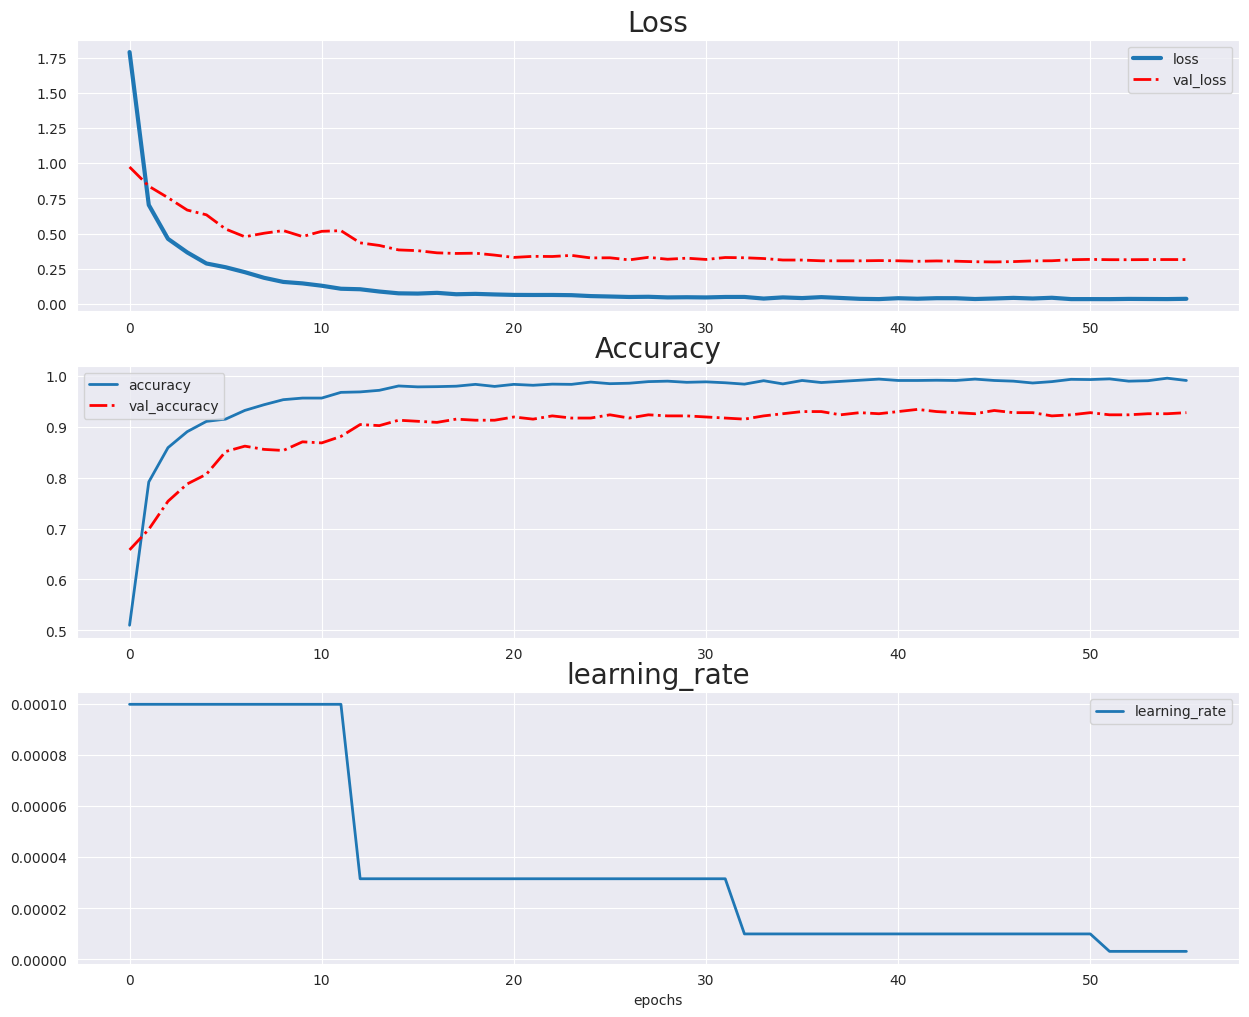

In [ ]:
x = np.arange(len(result_df))
fig, ax = plt.subplots(3, 1, figsize=(15, 12))
#  AX0 : Loss
ax[0].plot(x, result_df.loss, label='loss', linewidth=3)
ax[0].plot(x, result_df.val_loss, label='val_loss', linewidth=2, ls='-.', c='r')
ax[0].set_title('Loss', fontsize=20)
ax[0].legend()

#  AX1 : Loss
ax[1].plot(x, result_df.accuracy, label='accuracy', linewidth=2)
ax[1].plot(x, result_df.val_accuracy, label='val_accuracy', linewidth=2, ls='-.', c='r')
ax[1].set_title('Accuracy', fontsize=20)
ax[1].legend()

#  AX2 : Loss
ax[2].plot(x, result_df.lr, label='learning_rate', linewidth=2)
ax[2].set_title('learning_rate', fontsize=20)
ax[2].set_xlabel('epochs')
ax[2].legend()


plt.sharex=True


plt.show()

# **MODEL PREDICTION TEST DATASET**

In [ ]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : Brokoli Hijau Bagus
1 : Brokoli Hijau Jelek
2 : Daun Pepaya Bagus
3 : Daun Pepaya Jelek
4 : Daun Singkong Bagus
5 : Daun Singkong Jelek
6 : Daun Kelor Bagus
7 : Daun Kelor Jelek
8 : Kembang Kol Bagus
9 : Kembang Kol Jelek
10 : Kubis Hijau Bagus
11 : Kubis Hijau Jelek
12 : Paprika Merah Bagus
13 : Paprika Merah Jelek
14 : Sawi sendok atau Pakcoy Bagus
15 : Sawi sendok atau Pakcoy Jelek
16 : Tomat Merah Bagus
17 : Tomat Merah Jelek
18 : Wortel Nantes Bagus
19 : Wortel Nantes Jelek


In [ ]:
predictions = model.predict(test_generator)

16/16 [==============================] - 2s 97ms/step


In [ ]:
fig, ax = plt.subplots(nrows=5, ncols=6, figsize=(12, 10))
idx = 0

for i in range(5):
    for j in range(6):
        predicted_label = labels[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(test_generator[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator, batch_size=32)

16/16 [==============================] - 1s 54ms/step - loss: 0.2529 - accuracy: 0.9336


In [ ]:
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy} -> {test_accuracy*100:.2f}%")

Test Loss:     0.25293055176734924
Test Accuracy: 0.9336016178131104 -> 93.36%


# **PLOT CONFUSION MATRIX**

In [ ]:
y_hat = np.argmax(predictions, axis=1)
y_true = test_generator.classes

In [ ]:
cf_mtx = confusion_matrix(y_true, y_hat)

group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(20, 20)

plt.figure(figsize = (30, 20))
sns.heatmap(cf_mtx, xticklabels=labels.values(), yticklabels=labels.values(),
           cmap="YlGnBu", fmt="", annot=box_labels)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

In [ ]:
print(classification_report(y_true, y_hat, target_names=labels.values()))

                               precision    recall  f1-score   support

          Brokoli Hijau Bagus       0.94      1.00      0.97        29
          Brokoli Hijau Jelek       1.00      0.86      0.92        14
            Daun Pepaya Bagus       0.86      0.92      0.89        26
            Daun Pepaya Jelek       0.75      0.88      0.81        17
          Daun Singkong Bagus       0.95      0.88      0.91        24
          Daun Singkong Jelek       0.89      0.89      0.89        37
             Daun Kelor Bagus       0.96      1.00      0.98        25
             Daun Kelor Jelek       0.96      0.96      0.96        23
            Kembang Kol Bagus       1.00      0.97      0.98        33
            Kembang Kol Jelek       0.95      1.00      0.97        18
            Kubis Hijau Bagus       1.00      0.97      0.98        33
            Kubis Hijau Jelek       0.92      0.94      0.93        36
          Paprika Merah Bagus       1.00      1.00      1.00        25
     

# **WRONG PREDICT**

In [ ]:
y_true = np.array(y_true)
print(y_true.shape)

(497,)


In [ ]:
errors = (y_true - y_hat != 0)
error_indices = np.where(errors)[0]
y_true_errors = y_true[error_indices]
y_hat_errors = y_hat[error_indices]


In [ ]:
# Menghitung jumlah total prediksi
total_predictions = y_true.shape[0]

# Menghitung jumlah prediksi yang salah
total_errors = y_true_errors.shape[0]

# Menghitung persentase prediksi yang salah
error_percentage = (total_errors / total_predictions) * 100

print(f"Jumlah total prediksi: {total_predictions}")
print(f"Jumlah prediksi yang salah: {total_errors}")
print(f"Persentase prediksi yang salah: {error_percentage}%")

Jumlah total prediksi: 497
Jumlah prediksi yang salah: 33
Persentase prediksi yang salah: 6.639839034205232%


In [ ]:
test_images = test_generator.filenames
test_img = np.asarray(test_images)[errors]

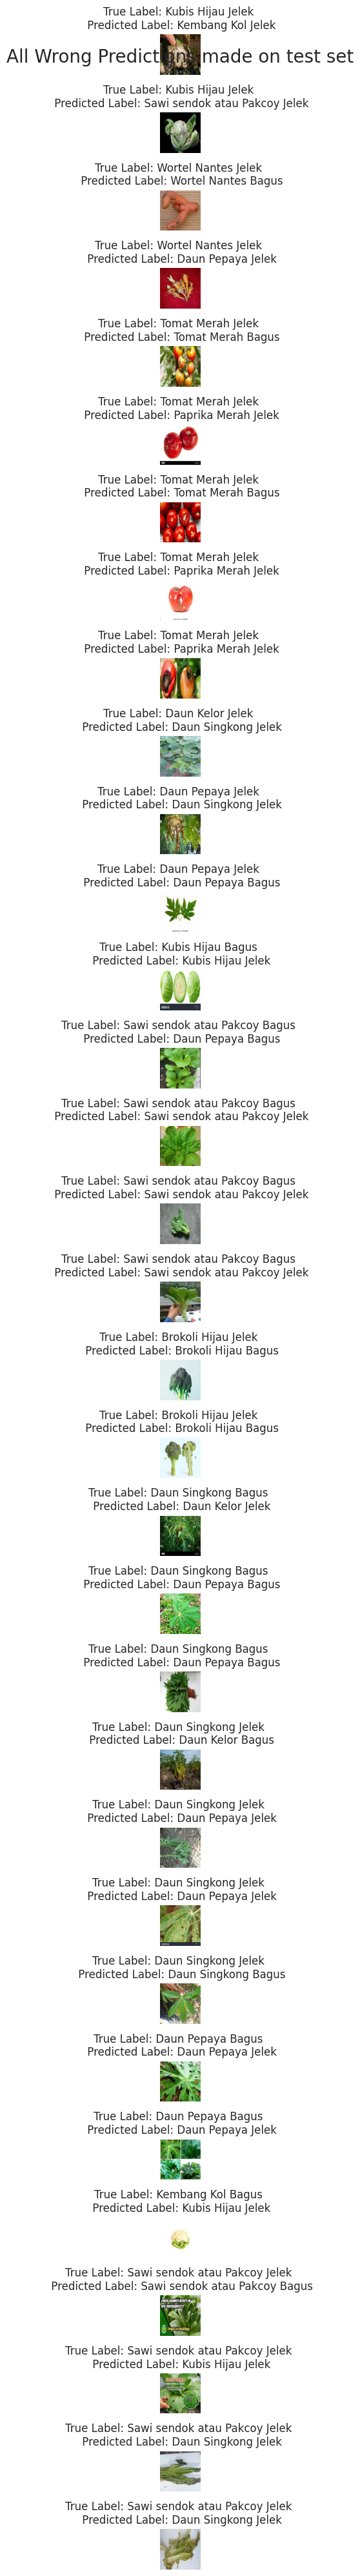

In [ ]:
fig, ax = plt.subplots(nrows=total_errors, ncols=1, figsize=(50, 40))

for idx, error in enumerate(y_true_errors):
    true_label = labels[error]
    predicted_label = labels[y_hat_errors[idx]]
    ax[idx].set_title(f"True Label: {true_label} \n Predicted Label: {predicted_label}")
    img_path = os.path.join(test_dir, test_img[idx])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax[idx].imshow(img)
    ax[idx].axis("off")

plt.tight_layout()
plt.suptitle('All Wrong Predictions made on test set', fontsize=20)
plt.show()


In [ ]:
# checkpoint callback, save base model weights in "MyModel.keras".
# So, we should load it
best_model = models.load_model('my_model.keras')

**h5**

In [ ]:
import tensorflow as tf
from tensorflow.python.saved_model.save import save

save_dir = os.path.join('/tmp/', 'mobilenetv2/my_model.h5')
model.save(save_dir)

# **Tensorflowjs**

In [ ]:
!pip3 install tensorflowjs

In [ ]:
!cd /tmp/mobilenetv2/
!tensorflowjs_converter --input_format=keras --output_format=tfjs_layers_model /tmp/mobilenetv2/my_model.h5 /tmp/tfjs_mobilenetv2/

In [ ]:
#menyimpan dalam bentuk zip
!zip -r /tmp/tfjs_mobilenetv2/modeldata.zip /tmp/tfjs_mobilenetv2/

# **EXPORT SavedModel**

In [ ]:
my_model= "my_model"

In [ ]:
tf.saved_model.save(model, my_model)

In [ ]:
import zipfile
import os

zip_file = "my_model.zip"
with zipfile.ZipFile(zip_file, 'w') as zipf:
    for root, dirs, files in os.walk(my_model):
        for file in files:
            zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), my_model))


In [ ]:
%%bash -s $my_model
saved_model_cli show --dir $1 --tag_set serve --signature_def serving_default

In [ ]:
loaded = tf.saved_model.load(my_model)

In [ ]:
print(list(loaded.signatures.keys()))
infer = loaded.signatures["serving_default"]
print(infer.structured_input_signature)
print(infer.structured_outputs)

# **TEST MODEL WITH ANOTHER IMAGES**

In [ ]:
# Read image classes
image_classes = os.listdir("/content/Vegetables/test")
image_classes

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Memuat model dari file .h5
model_path = '/content/MyModel.h5'  # Ganti dengan path ke model Anda
model = load_model(model_path)

# Classes sesuai dengan urutan pelatihan
classes = ['Daun Singkong Bagus',
 'Tomat Merah Bagus',
 'Daun\xa0Kelor Jelek',
 'Brokoli Hijau Jelek',
 'Kembang Kol Bagus',
 'Wortel Nantes Jelek',
 'Kubis Hijau Bagus',
 'Daun Singkong Jelek',
 'Paprika Merah Jelek',
 'Paprika Merah Bagus',
 'Daun Pepaya Jelek',
 'Daun Pepaya Bagus',
 'Kembang Kol Jelek',
 'Sawi sendok\xa0atau\xa0Pakcoy Bagus',
 'Daun\xa0Kelor Bagus',
 'Tomat Merah Jelek',
 'Wortel Nantes Bagus',
 'Brokoli Hijau Bagus',
 'Sawi sendok\xa0atau\xa0Pakcoy Jelek',
 'Kubis Hijau Jelek']  # Ganti dengan nama-nama kelas Anda

def preprocess_image(img_path):
    """
    Preprocess the input image to fit the model input requirements.

    Parameters:
    - img_path: Path to the image file.

    Returns:
    - img_array: Preprocessed image array.
    """
    img = image.load_img(img_path, target_size=(224, 224))  # Resize gambar
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Menambahkan dimensi batch
    img_array = img_array / 255.0  # Normalisasi gambar
    return img_array

def predict_image(model, img_path, classes):
    """
    Predict the class of the input image using the trained model.

    Parameters:
    - model: The trained model.
    - img_path: Path to the image file.
    - classes: List of class names.

    Returns:
    - prediction: Predicted class label.
    - confidence: Prediction confidence score.
    """
    img_array = preprocess_image(img_path)
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]
    confidence = predictions[0][predicted_class]
    return classes[predicted_class], confidence

# Path ke gambar yang ingin diprediksi
img_path = '/content/Vegetables/test/Daun Singkong Jelek/IMG_20240519_133855.jpg'  # Ganti dengan path ke gambar Anda

# Memproses dan memprediksi gambar
predicted_class, confidence = predict_image(model, img_path, classes)

# Menampilkan hasil prediksi
print(f"Predicted Class: {predicted_class}")
print(f"Confidence: {confidence * 100:.2f}%")

# Menampilkan gambar input
img = image.load_img(img_path)
plt.imshow(img)
plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence * 100:.2f}%")
plt.axis('off')
plt.show()


# **CONVERT THE SAVEMODEL TO TFLITE CONVERTER**

In [ ]:
import tensorflow as tf
# Save the entire model (including custom layers) as a Keras HDF5 file
model = tf.keras.models.load_model('/content/my_model.h5')

In [ ]:
# Convert the HDF5 model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Convert the model and save it as a TFLite file
tflite_model = converter.convert()

In [ ]:
with open('my_model.tflite', 'wb') as file:
  file.write(tflite_model)
print('Model converted to TensorFlow Lite successfully!')

**FILE BIN**

In [ ]:
# memuat model yang telah dilatih
model = tf.keras.models.load_model('my_model.h5')
# mendapatkan bobot
weights = model.get_weights()
#menyimpan model ke file .bin
with open('MyModel_weights.bin', 'wb') as f:
  for weight in weights:
    f.write(weight.tobytes())

# **VERIFY MODEL**

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Load the original Keras model
original_model = tf.keras.models.load_model('/content/my_model.h5')

# Load the TensorFlow Lite model
interpreter = tf.lite.Interpreter(model_path='/content/my_model.tflite')
interpreter.allocate_tensors()

# Define the input shape
input_shape = (224, 224, 3) # Assuming your images are of size 224x224x3 (RGB)

# Create ImageDataGenerator with disabled augmentation for verification
test_generator = ImageDataGenerator(rescale=1./255)

# Create an iterator for test data
test_generator = test_generator.flow_from_directory(directory='/content/Vegetables/test',
                                                    target_size=(224, 224),
                                                    batch_size=32, # Adjust batch size as needed
                                                    class_mode='categorical')

# Get class indices
class_indices = test_generator.class_indices
index_to_class = {v: k for k, v in class_indices.items()}

# Compare predictions from both models
def compare_predictions(batch_images):
    # Get predictions from the original Keras model
    original_predictions = original_model.predict(batch_images)

    # Get predictions from the TensorFlow Lite model
    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]
    for i in range(len(batch_images)):
      # Add a batch dimension (1,) to the image
      interpreter.set_tensor(input_details['index'], np.expand_dims(batch_images[i], axis=0))
      interpreter.invoke()
      tflite_predictions = interpreter.get_tensor(output_details['index'])

      # Compare predictions
      original_pred = np.argmax(original_predictions[i])
      tflite_pred = np.argmax(tflite_predictions)

      if original_pred != tflite_pred:
        print(f"Error: Mismatch in predictions for image {i}")
        print(f"Original: {original_pred} ({index_to_class[original_pred]})")
        print(f"TF Lite: {tflite_pred} ({index_to_class[tflite_pred]})")

      else:
        print(f"Image {i} prediction: {original_pred} ({index_to_class[original_pred]})")

# Verification using ImageDataGenerator
for batch_images, _ in test_generator:
  compare_predictions(batch_images)
  # Optional: Break after the first batch to avoid long output
  break
